In [1]:
# From here: https://carpentries-incubator.github.io/SDC-BIDS-fMRI/05-data-cleaning-with-nilearn/index.html
# Kernel = UFRC Python-3.8 OR Steve's Neuroimaging kernel
# See clean_fmriprep.py for more

# Import necessary toolboxes
from nilearn import image as nimg
from nilearn import plotting as nplot
import nibabel as nib
import bids # https://bids-standard.github.io/pybids/generated/bids.layout.BIDSLayout.html
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline




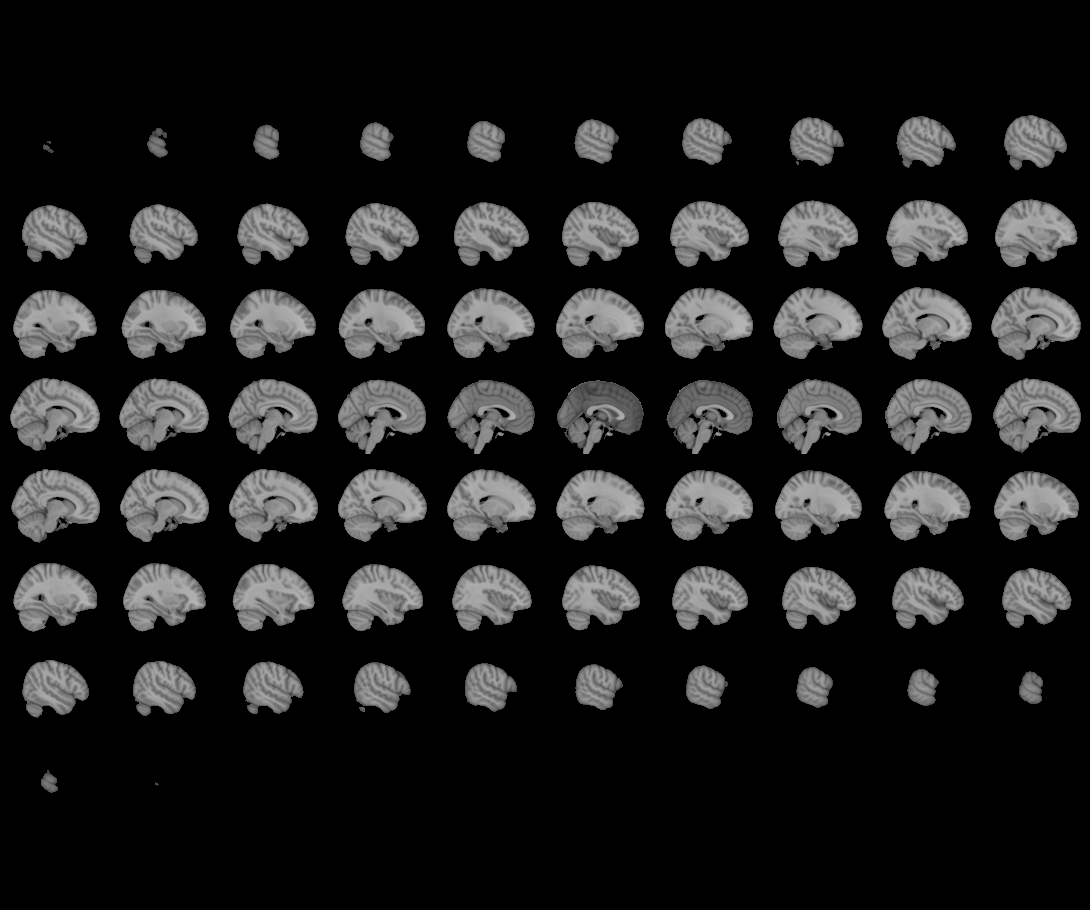
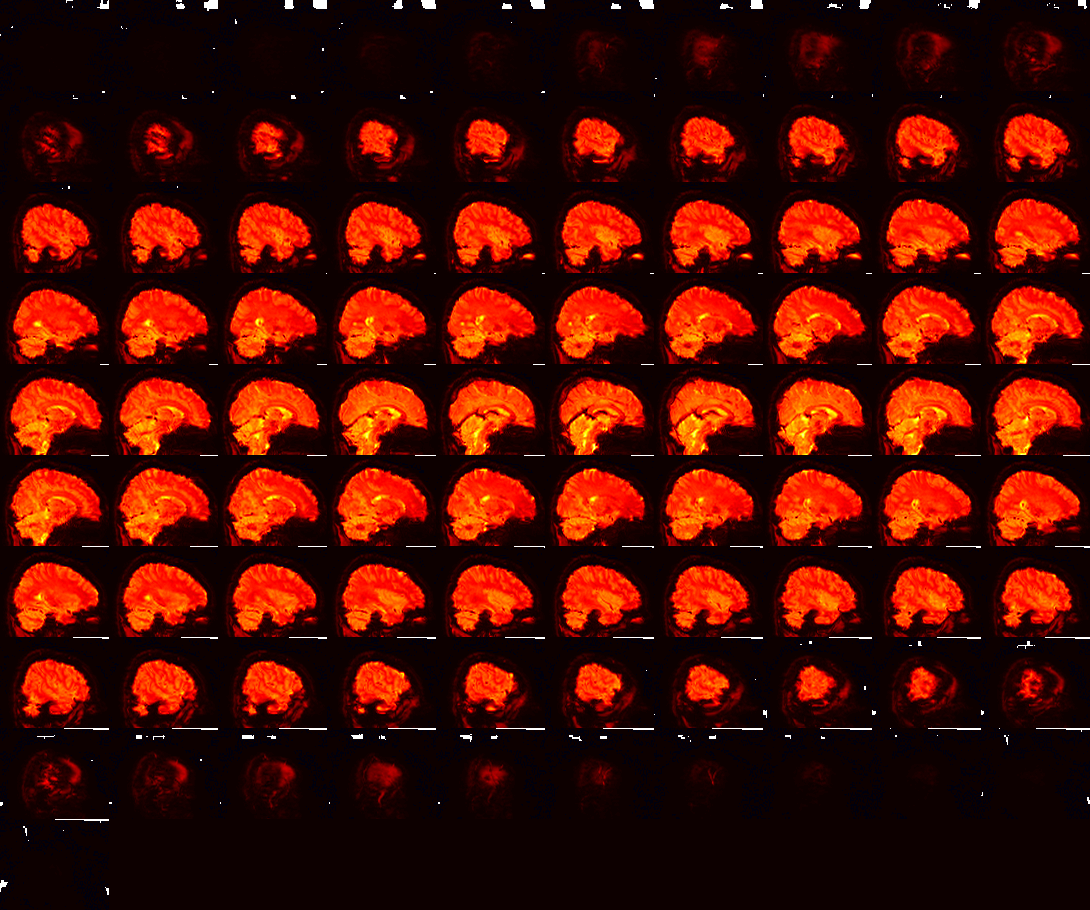

In [2]:
# The data we will load in and preprocess. 

test = nimg.load_img('/blue/stevenweisberg/share/DSP_fMRI/derivatives/sub-dspfmri12002/func/sub-dspfmri12002_task-dspfmri_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')

nplot.view_img(test.slicer[:,:,:,200])


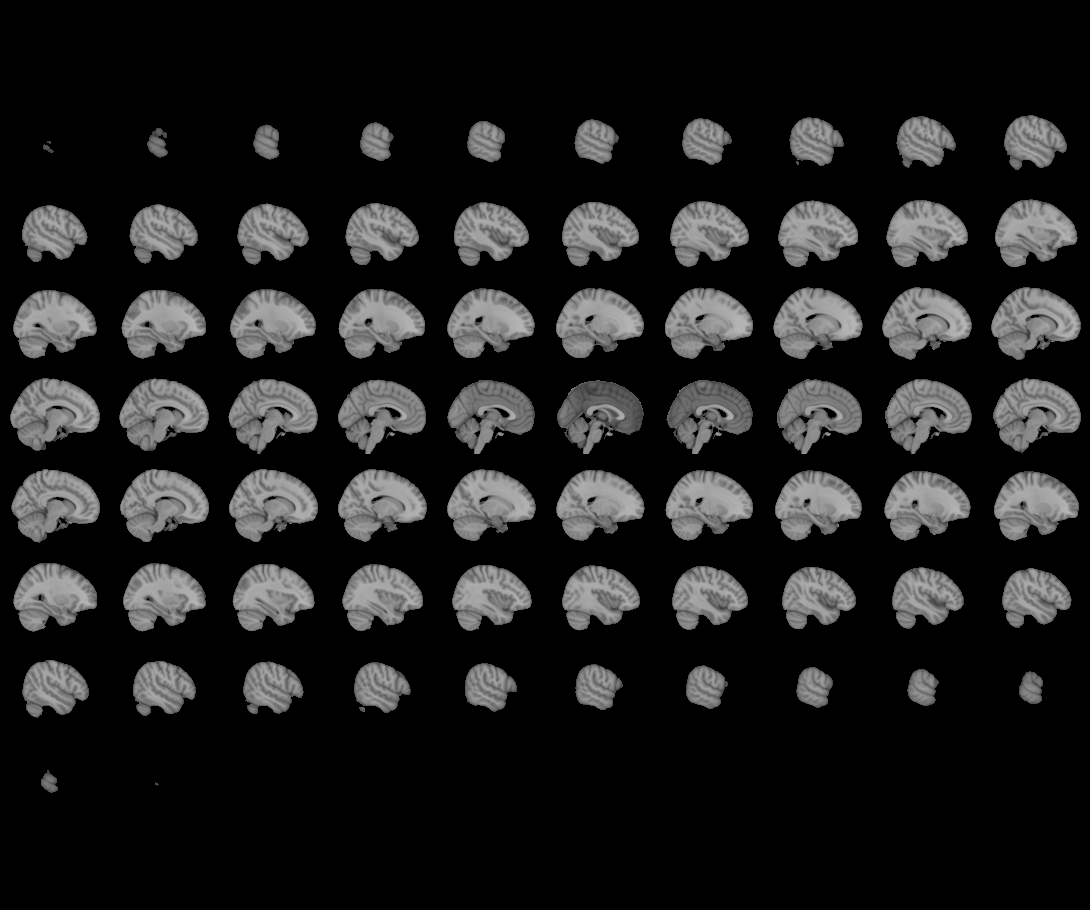
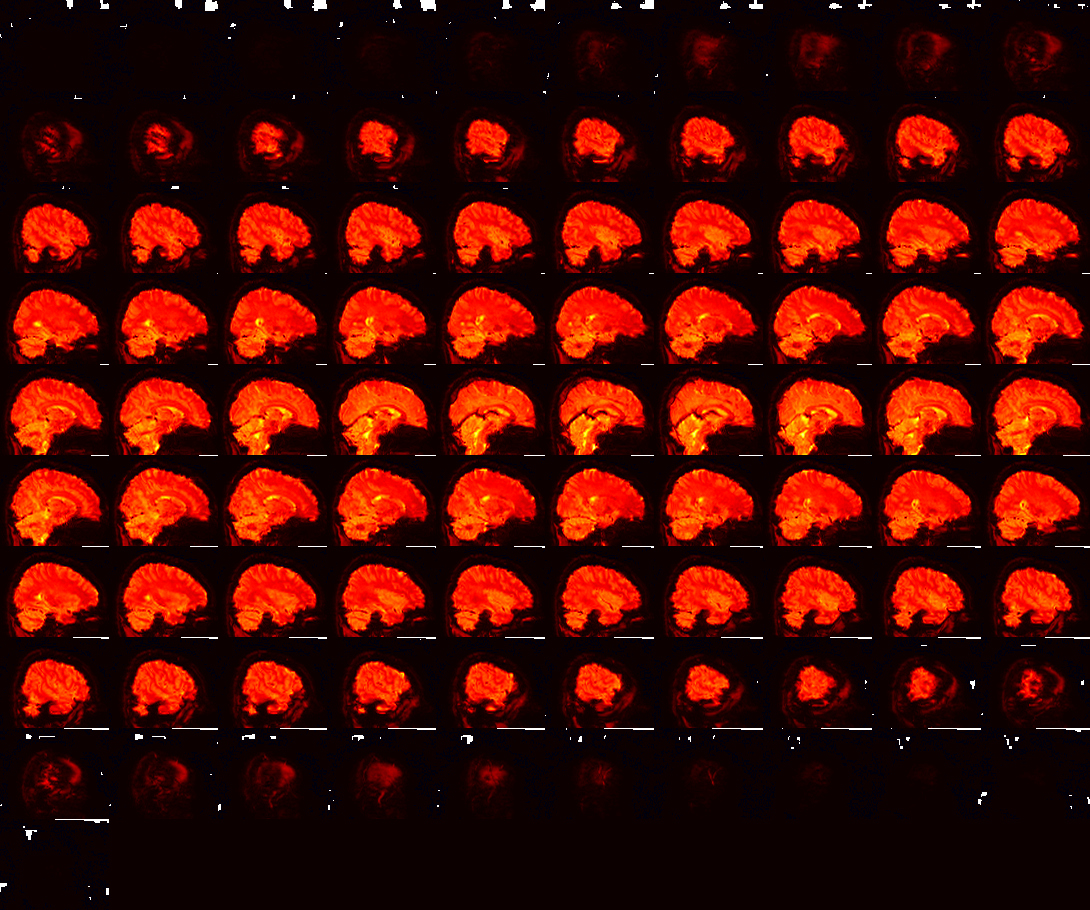

In [3]:
nplot.view_img(test.slicer[:,:,:,50])

In [2]:
# Give a subject ID here
sub = 'dspfmri11002'
task = 'dspfmri'
space = 'MNI152NLin2009cAsym'
# BIDS directory here
fmriprep_dir = '/blue/stevenweisberg/share/DSP_fMRI/derivatives'


In [3]:
# This tells us where the BIDS directory is.
# https://bids-standard.github.io/pybids/generated/bids.layout.BIDSLayout.html
layout = bids.BIDSLayout(fmriprep_dir,validate=False,
                        config=['bids','derivatives'])

print(layout.get_subjects())

['dspfmri11002', 'dspfmri11004', 'dspfmri11005', 'dspfmri11006', 'dspfmri11007', 'dspfmri11008', 'dspfmri11009', 'dspfmri12002', 'dspfmri12003', 'dspfmri12005', 'dspfmri12006', 'dspfmri12007', 'dspfmri12008', 'dspfmri12009', 'dspfmri12011', 'dspfmri12012', 'dspfmri21002', 'dspfmri22003', 'dspfmri22004']


In [4]:
# We'll grab all functional files with the following parameters


func_files = layout.get(subject=sub, 
                        task=task,
                        desc='preproc',
                        suffix='bold',
                        space=space,
                        extension='nii.gz',
                        return_type='file')

mask_files = layout.get(subject=sub,
                        datatype='func', 
                        task=task,
                        desc='brain',
                        suffix='mask',
                        space=space,
                        extension="nii.gz",
                        return_type='file')

confound_files = layout.get(subject=sub,
                            datatype='func', 
                            task=task,
                            desc='confounds',
                            extension="tsv",
                            return_type='file')

print(func_files, confound_files)

['/blue/stevenweisberg/share/DSP_fMRI/derivatives/sub-dspfmri11002/func/sub-dspfmri11002_task-dspfmri_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/blue/stevenweisberg/share/DSP_fMRI/derivatives/sub-dspfmri11002/func/sub-dspfmri11002_task-dspfmri_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/blue/stevenweisberg/share/DSP_fMRI/derivatives/sub-dspfmri11002/func/sub-dspfmri11002_task-dspfmri_run-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/blue/stevenweisberg/share/DSP_fMRI/derivatives/sub-dspfmri11002/func/sub-dspfmri11002_task-dspfmri_run-4_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'] ['/blue/stevenweisberg/share/DSP_fMRI/derivatives/sub-dspfmri11002/func/sub-dspfmri11002_task-dspfmri_run-1_desc-confounds_timeseries.tsv', '/blue/stevenweisberg/share/DSP_fMRI/derivatives/sub-dspfmri11002/func/sub-dspfmri11002_task-dspfmri_run-2_desc-confounds_timeseries.tsv', '/blue/stevenweisberg/share/DSP_fMRI/derivatives/sub-dspfmri11002/func/sub-dspfm

In [5]:
# Just an example with one functional file. 

func_file = func_files[0]
mask_file = mask_files[0]
confound_file = confound_files[0]

meta_data_func = layout.get_metadata(func_file)
print(confound_file + '\n' + func_file + '\n' + mask_file)


/blue/stevenweisberg/share/DSP_fMRI/derivatives/sub-dspfmri11002/func/sub-dspfmri11002_task-dspfmri_run-1_desc-confounds_timeseries.tsv
/blue/stevenweisberg/share/DSP_fMRI/derivatives/sub-dspfmri11002/func/sub-dspfmri11002_task-dspfmri_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
/blue/stevenweisberg/share/DSP_fMRI/derivatives/sub-dspfmri11002/func/sub-dspfmri11002_task-dspfmri_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz


In [6]:
#Delimiter is \t --> tsv is a tab-separated spreadsheet
confound_df = pd.read_csv(confound_file, delimiter='\t')
confound_df.head()

print(confound_df.shape)

(288, 316)


In [7]:
# From David Smith: 
# Also, here: https://www.sciencedirect.com/science/article/pii/S1053811917310972?via%3Dihub
# Delimiter is \t --> tsv is a tab-separated spreadsheet

print(f'Full confounds file {confound_df.shape}')

# Motion outliers (fd threshold from fmriprep defaults)
motion_outliers = [col for col in confound_df.columns if 'motion_outlier' in col]
# PCA first 5 components
a_comp_cor =['a_comp_cor_00','a_comp_cor_01','a_comp_cor_02','a_comp_cor_03','a_comp_cor_04','a_comp_cor_05'] # use aCompCor instead
# In case of dummy scans
non_steady_state = [col for col in confound_df.columns if col.startswith('non_steady_state')]
# Motion regressors
motion = ['trans_x','trans_y','trans_z','rot_x','rot_y','rot_z']
fd = ['framewise_displacement']

# Combine them all
filter_col=np.concatenate([motion_outliers,motion,fd,a_comp_cor])
confound_df = confound_df[filter_col]
# Fill nans with 0's
confound_df = confound_df.fillna(0)

# Print all confound names
print(confound_df.columns)

confounds_matrix = confound_df.values

#np.savetxt('/blue/stevenweisberg/share/DSP_fMRI/derivatives/clean_data/sub-dspfmri11002/confounds/sub-dspfmri11002_task-dspfmri_run-1_desc-confounds_trimmed.csv',
#           confounds_matrix,delimiter=",")

print(confounds_matrix.shape)


Full confounds file (288, 316)
Index(['motion_outlier00', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y',
       'rot_z', 'framewise_displacement', 'a_comp_cor_00', 'a_comp_cor_01',
       'a_comp_cor_02', 'a_comp_cor_03', 'a_comp_cor_04', 'a_comp_cor_05'],
      dtype='object')
(288, 14)


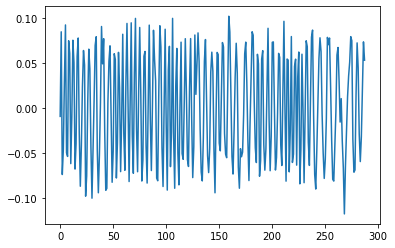

In [8]:
plt.plot(confound_df['a_comp_cor_00'])

In [11]:
#First we'll load in our data and check the shape
raw_func_img = nimg.load_img(func_file)
raw_func_img.shape


(129, 153, 78, 288)

In [18]:
#Set some constants Yeo et al., 2011
HIGH_PASS= 0.009
LOW_PASS = 0.08
T_R = meta_data_func['RepetitionTime']

#Clean!
clean_img = nimg.clean_img(raw_func_img,confounds=confounds_matrix,detrend=True,standardize=True,
                         low_pass=LOW_PASS,high_pass=HIGH_PASS,t_r=T_R, mask_img=mask_file)

nilearn.plotting.view_img(clean_img.slicer[:,:,:,50])


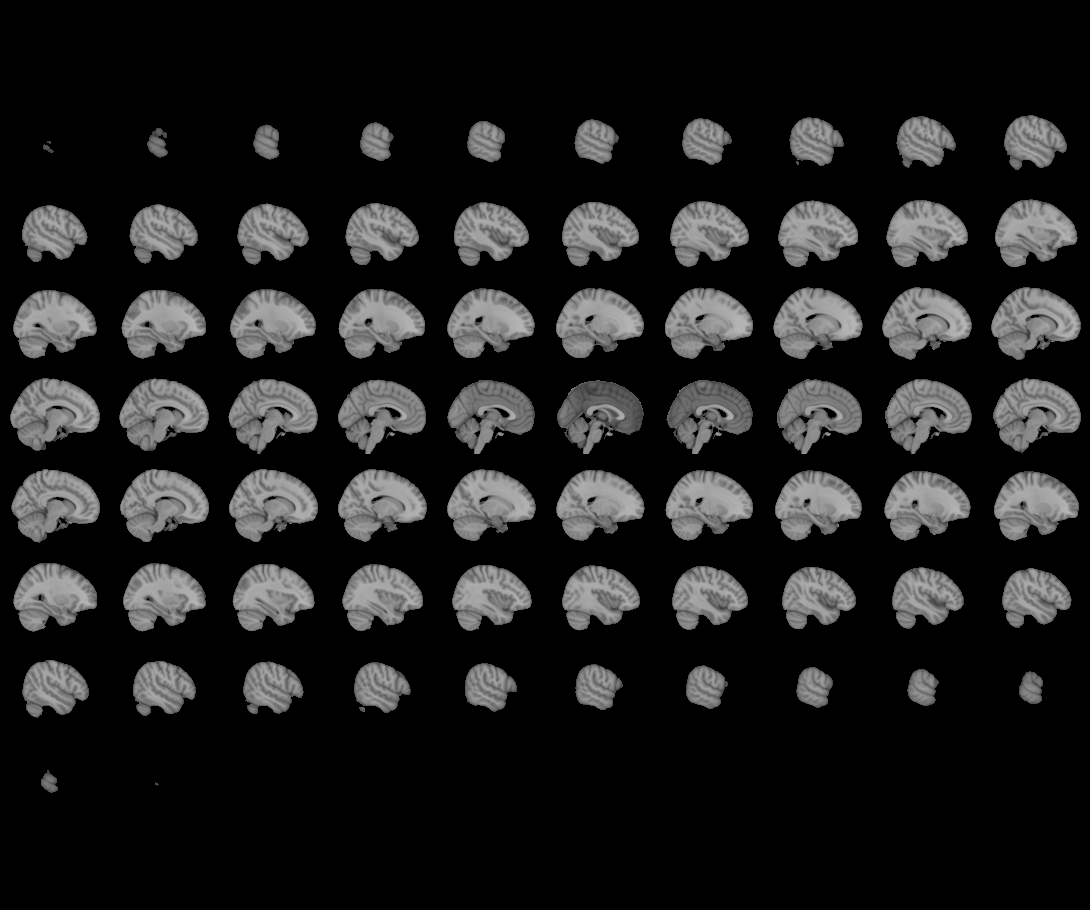
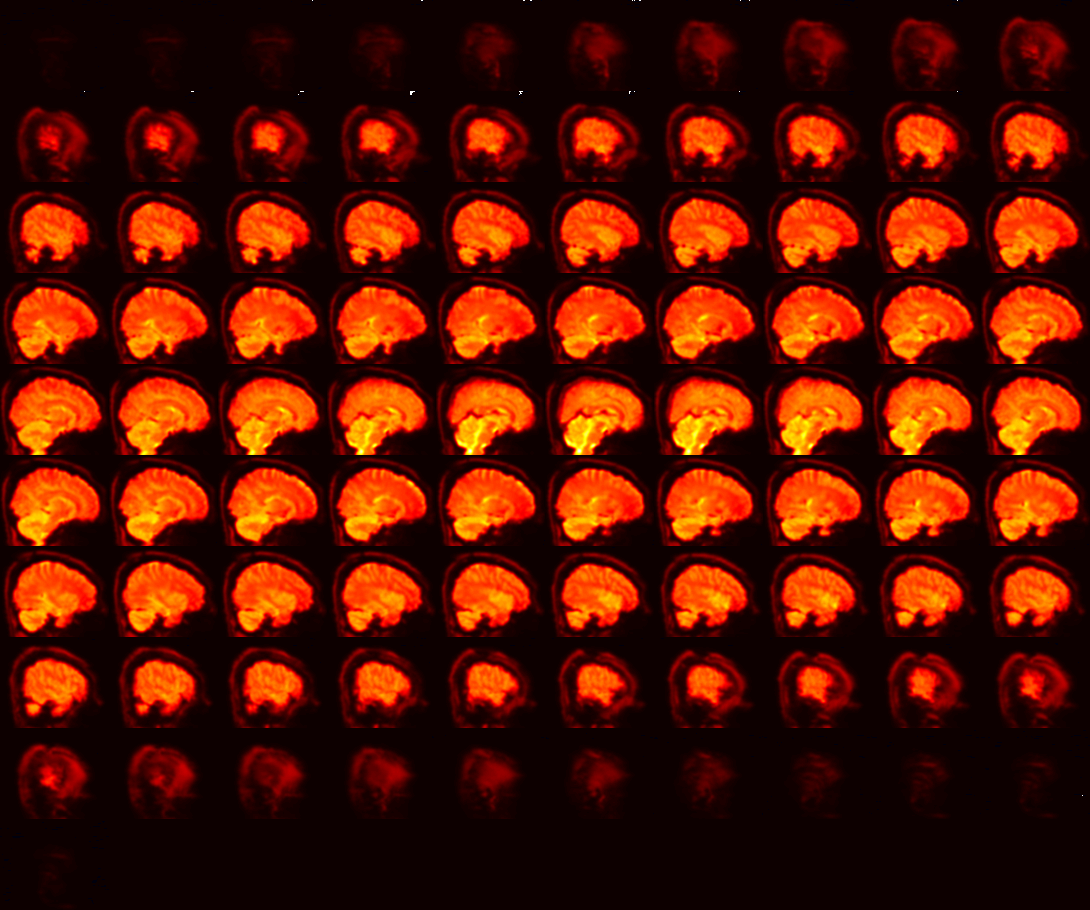

In [20]:
# Smooth!

clean_img_smooth = nilearn.image.smooth_img(clean_img, 5)

nilearn.plotting.view_img(clean_img.slicer[:,:,:,50])

In [ ]:
# On to the first level model!